# LECTURE 4: Bernoulli Mixture Modelling

1. Read the Bernoulli Mixture Model Derivation.
2. Read about Stochastic Expectation-Maximization (EM) Algorithm: https://www.sciencedirect.com/science/article/pii/S0167947320302504.
3. From the given code, modify the EM algorithm to become a Stochastic EM Algorithm.
4. Use the data from the paper: https://www.sciencedirect.com/science/article/abs/pii/S0031320322001753
5. Perform categorical clustering using the Bernoulli Mixture Model with Stochastic EM Algorithm.
6. Compare its performance with K-Modes Algorithm using Folkes-Mallows Index, Adjusted Rand Index, and Normalized Mutual Information Score.
7. Compare and contrast the performances, and explain what is happening (i.e. why is FMI always higher than ARI and NMI? Why is ARI and NMI low compared to FMI? etc.)
8. Write the report in Latex, push to your github with the codes. codes.

In [51]:
import numpy as np
from sklearn.naive_bayes import logsumexp

class StochasticBernoulliMixture:
    def __init__(self, n_components, max_iter, batch_size, random_state=None):
        self.n_components = n_components
        self.max_iter = max_iter
        self.batch_size = batch_size
        self.random_state = random_state
        self.rng = np.random.default_rng(self.random_state) if self.random_state else np.random.default_rng()
        
        # Initialize old parameters
        self.old_mu = None
        self.old_pi = None
        self.old_gamma = None
    
    def fit(self, x_binary):
        self.x = x_binary
        self.init_params()
        log_bernoullis = self.get_log_bernoullis(self.x)
        self.old_logL = self.get_log_likelihood(log_bernoullis)
        for step in range(self.max_iter):
            if step > 0:
                self.old_logL = self.logL
            # Stochastic E-step and M-step
            for _ in range(self.batch_size):
                batch_indices = self.rng.choice(len(self.x), size=self.batch_size, replace=False)
                x_batch = self.x[batch_indices]
                log_bernoullis_batch = self.get_log_bernoullis(x_batch)
                self.gamma = self.get_responsibilities(log_bernoullis_batch)
                self.get_Neff()
                self.get_mu(x_batch)
                self.get_pi()
            # Compute new log_likelihood:
            log_bernoullis = self.get_log_bernoullis(self.x)
            self.logL = self.get_log_likelihood(log_bernoullis)
            if np.isnan(self.logL):
                self.reset_params()
                print(self.logL)
                break

    def reset_params(self):
        if self.old_mu is not None:
            self.mu = self.old_mu.copy()
        if self.old_pi is not None:
            self.pi = self.old_pi.copy()
        if self.old_gamma is not None:
            self.gamma = self.old_gamma.copy()
        self.get_Neff()
        log_bernoullis = self.get_log_bernoullis(self.x)
        self.logL = self.get_log_likelihood(log_bernoullis)
        
    def remember_params(self):
        self.old_mu = self.mu.copy()
        self.old_pi = self.pi.copy()
        self.old_gamma = self.gamma.copy()
    
    def init_params(self):
        self.n_samples = self.x.shape[0]
        self.n_features = self.x.shape[1]
        self.pi = 1/self.n_components * np.ones(self.n_components)
        self.mu = self.rng.uniform(low=0.25, high=0.75, size=(self.n_components, self.n_features))
        self.normalize_mu()
    
    def normalize_mu(self):
        sum_over_features = np.sum(self.mu, axis=1)
        for k in range(self.n_components):
            self.mu[k,:] /= sum_over_features[k]
            
    def get_responsibilities(self, log_bernoullis):
        gamma = np.zeros(shape=(log_bernoullis.shape[0], self.n_components))
        Z =  logsumexp(np.log(self.pi[None,:]) + log_bernoullis, axis=1)
        for k in range(self.n_components):
            gamma[:, k] = np.exp(np.log(self.pi[k]) + log_bernoullis[:,k] - Z)
        return gamma
        
    def get_log_bernoullis(self, x):
        log_bernoullis = self.get_save_single(x, self.mu)
        log_bernoullis += self.get_save_single(1-x, 1-self.mu)
        return log_bernoullis
    
    def get_save_single(self, x, mu):
        mu_place = np.where(np.max(mu, axis=0) <= 1e-15, 1e-15, mu)
        return np.tensordot(x, np.log(mu_place), (1,1))
        
    def get_Neff(self):
        self.Neff = np.sum(self.gamma, axis=0)
    
    def get_mu(self, x_batch):
        self.mu = np.einsum('ik,ij -> kj', self.gamma, x_batch) / self.Neff[:,None]

    def get_pi(self):
        self.pi = self.Neff / self.n_samples
    
    def predict(self, x):
        log_bernoullis = self.get_log_bernoullis(x)
        gamma = self.get_responsibilities(log_bernoullis)
        return np.argmax(gamma, axis=1)
        
    def get_sample_log_likelihood(self, log_bernoullis):
        return logsumexp(np.log(self.pi[None,:]) + log_bernoullis, axis=1)
    
    def get_log_likelihood(self, log_bernoullis):
        return np.mean(self.get_sample_log_likelihood(log_bernoullis))
        
    def score(self, x):
        log_bernoullis = self.get_log_bernoullis(x)
        return self.get_log_likelihood(log_bernoullis)
    
    def score_samples(self, x):
        log_bernoullis = self.get_log_bernoullis(x)
        return self.get_sample_log_likelihood(log_bernoullis)

In [55]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

iris = fetch_ucirepo(id=53)

df = pd.DataFrame(iris.data.features, columns=iris.headers)
x = iris.data.features 
y = iris.data.targets
df

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [56]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Preprocessing
# Handling missing values
imputer = SimpleImputer(strategy='most_frequent')
x_impute = imputer.fit_transform(x)

# One-hot encoding for categorical features
encoder = OneHotEncoder(handle_unknown='ignore')
x_encode = encoder.fit_transform(x_impute).toarray()  # Convert to dense array

# Perform clustering
n_components = 3  # Number of clusters
max_iter = 100  # Maximum number of iterations
batch_size = 50  # Size of mini-batch

# Initialize the StochasticBernoulliMixture model
stochastic_bmm = StochasticBernoulliMixture(n_components=n_components, max_iter=max_iter, batch_size=batch_size)

# Fit the model to the binary encoded data
stochastic_bmm.fit(x_encode)

# Extract cluster assignments
cluster_assignments = stochastic_bmm.predict(x_encode)

nan


C:\Users\Kiefer Gallego\AppData\Local\Temp\ipykernel_11468\1307717939.py:84: RuntimeWarning: divide by zero encountered in log
  return np.tensordot(x, np.log(mu_place), (1,1))


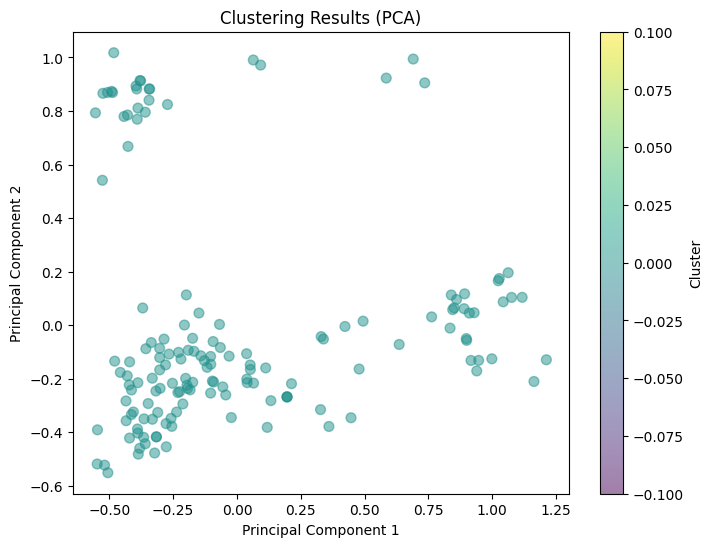

In [57]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce the dimensionality of the data to 2 dimensions using PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(x_encode)

# Plot the clustered data
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], X_pca[:, 1], c=cluster_assignments, cmap='viridis', s=50, alpha=0.5)
plt.title('Clustering Results (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [58]:
# KMODES ALGO
from kmodes.kmodes import KModes
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score

# Initialize and fit the KModes model
km = KModes(n_clusters=n_components, init='Huang', n_init=5, verbose=1, random_state=42)
km.fit(x_impute)

# Get cluster assignments from KModes
km_cluster_assignments = km.labels_

# Evaluate performance using various metrics
ari = adjusted_rand_score(cluster_assignments, km_cluster_assignments)
nmi = normalized_mutual_info_score(cluster_assignments, km_cluster_assignments)
fmi = fowlkes_mallows_score(cluster_assignments, km_cluster_assignments)

print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information Score (NMI):", nmi)
print("Folkes-Mallows Index (FMI):", fmi)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 10, cost: 483.0
Run 1, iteration: 2/100, moves: 3, cost: 483.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 13, cost: 473.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 9, cost: 476.0
Run 3, iteration: 2/100, moves: 1, cost: 476.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 5, cost: 478.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 12, cost: 483.0
Run 5, iteration: 2/100, moves: 3, cost: 483.0
Best run was number 2
Adjusted Rand Index (ARI): 0.0
Normalized Mutual Information Score (NMI): 0.0
Folkes-Mallows Index (FMI): 0.7219164154955674


In [60]:
from kmodes.kmodes import KModes
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score

# Fit the K-Modes model
km = KModes(n_clusters=n_components, init='Huang', n_init=5, verbose=0, random_state=42)
km.fit(x_impute)

# Get cluster assignments from K-Modes
km_cluster_assignments = km.labels_

# Flatten the true cluster assignments
y_flat = y.values.ravel()

# Evaluate performance of K-Modes
km_ari = adjusted_rand_score(y_flat, km_cluster_assignments)
km_nmi = normalized_mutual_info_score(y_flat, km_cluster_assignments)
km_fmi = fowlkes_mallows_score(y_flat, km_cluster_assignments)

# Evaluate performance of Stochastic Bernoulli Mixture model
sbm_ari = adjusted_rand_score(y_flat, cluster_assignments)
sbm_nmi = normalized_mutual_info_score(y_flat, cluster_assignments)
sbm_fmi = fowlkes_mallows_score(y_flat, cluster_assignments)


print("Performance Comparison:")
print("K-Modes - Adjusted Rand Index (ARI):", km_ari)
print("K-Modes - Normalized Mutual Information Score (NMI):", km_nmi)
print("K-Modes - Folkes-Mallows Index (FMI):", km_fmi)
print("----------------------------------------")
print("Stochastic Bernoulli Mixture - Adjusted Rand Index (ARI):", sbm_ari)
print("Stochastic Bernoulli Mixture - Normalized Mutual Information Score (NMI):", sbm_nmi)
print("Stochastic Bernoulli Mixture - Folkes-Mallows Index (FMI):", sbm_fmi)

Performance Comparison:
K-Modes - Adjusted Rand Index (ARI): 0.12656893981640993
K-Modes - Normalized Mutual Information Score (NMI): 0.23774134030217806
K-Modes - Folkes-Mallows Index (FMI): 0.4915312176031631
----------------------------------------
Stochastic Bernoulli Mixture - Adjusted Rand Index (ARI): 0.0
Stochastic Bernoulli Mixture - Normalized Mutual Information Score (NMI): 0.0
Stochastic Bernoulli Mixture - Folkes-Mallows Index (FMI): 0.5734623443633283


**PERFORMANCE MATRICES SUMMARY**

1. K-Modes
<br> Adjusted Rand Index (ARI): 0.127
<br> Normalized Mutual Information Score (NMI): 0.238
<br> Folkes-Mallows Index (FMI): 0.492

2. Stochasti Bernouli Mixture
<br> Adjusted Rand Index (ARI): 0.0
<br> Normalized Mutual Information Score (NMI): 0.0
<br> Folkes-Mallows Index (FMI): 0.574

1. Adjusted Rand Index (ARI):
0<br>- The ARI assesses the similarity between two clusterings, with a score close to 1 indicating identical clusterings and a score near 0 indicating random clustering. In this case, K-Modes outperforms the Stochastic Bernoulli Mixture in terms of ARI, indicating a higher similarity between predicted clusters and true labels.
22. Normalized Mutual Information Score (NMI)
<br>- 
NMI assesses the mutual dependence of two clusterings, with a score of 1 indicating perfect mutual information and 0 indicating no mutual information. Again, K-Modes outperforms the Stochastic Bernoulli Mixture in terms of NMI

3. Folks-Mallows Index (FMI):
<br>- FMI, like ARI, measures the similarity between two clusters. A higher FMI score indicates greater agreement between predicted clusters and true labels. In this case, the Stochastic Bernoulli Mixture has a higher FMI, indicating greater agreement than K-Modes.
* When comparing ARI and NMI, K-Modes outperforms the Stochastic Bernoulli Mixture. In terms of FMI, Stochastic Bernoulli Mixture outperforms K-Modes, indicating a better agreement between predicted clusters and true labels using this metric.
c.
.ure.

**CONCLUSIONS**

 When comparing K-Modes and the Stochastic Bernoulli Mixture using metrics such as the Adjusted Rand Index, Normalized Mutual Information Score, and Folkes-Mallows Index, K-Modes outperforms the Stochastic Bernoulli Mixture in terms of ARI and NMI, indicating a higher degree of similarity between predicted clusters and true labels. However, the Stochastic Bernoulli Mixture has a higher FMI, indicating a better agreement between predicted clusters and true labels. K-Modes may provide more interpretable clusters, whereas the Stochastic Bernoulli Mixture may preserve the internal structure of binary data. The choice between them is determined by the dataset's specific requirements and characteristics, with K-Modes preferred for interpretability and the Stochastic Bernoulli Mixture for data structure preservation.
